# Projeto fim a fim utilizando Regressão Linear
---

# 1.0 Introdução

O dataset utilizado possui notas dos alunos de vários cursos da UFRN do ano de 2015 a 2017. A ideia é predizer a nota do discente da terceira unidade a partir das notas da primeira e segunda unidade da  matéria de Cálculo I.

Para padronizar o conteúdo estudado em cada unidade pelos alunos, será selecionado apenas os alunos do curso de Ciências e Tecnologia, visto que a amostra é um conjunto de dados com uma quantidade significante.

# 2.0 Carregando os dados

## 2.1 Acesar arquivo do drive

In [139]:
#1. Install a Drive FUSE wrapper google-drive-ocamlfuse.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [ ]:
#2. Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [140]:
#3. Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [4]:
#4. Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [ ]:
# commando to umount 
# !fusermount -u ML

In [ ]:
import os
os.chdir("/content/")

In [3]:
!ls

adc.json  datasets  drive  sample_data


## 2.2 Carregando os arquivos locais

In [ ]:
!cp -r drive/Mestrado/Primeiro/MachineLearning/MyActivities/LinearRegression/datasets/ /content/

In [8]:
!ls datasets/

componentes-curriculares-presenciais.csv  matriculas
cursos-graduacao.csv			  turmas


## 2.3 Estrutura dos dados

In [1]:
import pandas as pd

In [2]:
df_matriculas = pd.DataFrame()

# importando matriculas de 2015 a 2017
for i in range(15,18):
    for j in range(1,3):
        print('20'+str(i)+str(j))
        df_matricula = pd.read_csv('datasets/matriculas/matriculas-de-20'+str(i)+str(j)+'.csv',sep=';')
        #concatena as tabelas
        df_matriculas = pd.concat([df_matriculas, df_matricula])
        
print("\nDataFrame de Matrículas:")
print(df_matriculas.shape)
display(df_matriculas.head())

20151
20152
20161
20162
20171


/home/andressa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if __name__ == '__main__':


20172

DataFrame de Matrículas:
(4089836, 11)


,Unnamed: 10,descricao,discente,faltas_unidade,id_curso,id_turma,media_final,nota,numero_total_faltas,reposicao,unidade
0,NaN,REPROVADO,8833c0e056f90497742882bfcc81b685,0.0,100300443.0,57562481,0.0,0.0,0.0,f,2.0
1,NaN,REPROVADO,8833c0e056f90497742882bfcc81b685,0.0,100300443.0,57562481,0.0,0.0,0.0,f,3.0
2,NaN,APROVADO,7a0a661326418111f7d17aab098757aa,0.0,100300443.0,57562481,8.9,8.9,0.0,f,1.0
3,NaN,APROVADO,7a0a661326418111f7d17aab098757aa,0.0,100300443.0,57562481,8.9,8.9,0.0,f,2.0
4,NaN,APROVADO,7a0a661326418111f7d17aab098757aa,0.0,100300443.0,57562481,8.9,8.9,0.0,f,3.0


Esse dataset representa a relação das matrículas em componentes dos cursos da instituição. Cada coluna significa:

- **descrição**: Situação final do discente nessa turma.
- **discente**: Identificador do discente da matrícula.
- **faltas_unidade**: Quantidade de faltas na unidade.
- **id_curso**: Identificador do curso do discente.
- **id_turma**: Identificador da turma do discente.
- **media_final**: Média final do discente.
- **nota**: Nota do discente na unidade.
- **numero_total_faltas**: Quantidade total de faltas.
- **reposição**: Indica se o discente ficou em reposição.
- **unidade**: Unidade corrente do período letivo.

In [3]:
df_matriculas.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4089836 entries, 0 to 632453
Data columns (total 11 columns):
Unnamed: 10            0 non-null float64
descricao              4089836 non-null object
discente               4089836 non-null object
faltas_unidade         3467465 non-null float64
id_curso               4068862 non-null float64
id_turma               4089836 non-null int64
media_final            3510693 non-null float64
nota                   3356750 non-null float64
numero_total_faltas    3609525 non-null float64
reposicao              3467465 non-null object
unidade                3467465 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 374.4+ MB


- A primeira coluna do dataset é formado apenas por elementos nulos;
- Apenas as colunas "descrição", "discente" e "id_turma" não possuem elementos nulos.

In [4]:
# concatenar todas as turmas de 2015 a 2017
df_turmas = pd.DataFrame()

for i in range(15,18):
    for j in range(1,3):
        print("20"+str(i)+str(j))
        f = open('datasets/turmas/turmas-20'+str(i)+str(j)+'.csv')
        d = f.read()
        d = d.replace("\n","")
        x = d.split("\";\"")
        a = []
        step = 25
        for b in range(0, len(x), step):
            a.append(x[b:b+step])
        df = pd.DataFrame(a[1:],columns=['id_turma']+a[0][1:])
        df_turmas = pd.concat([df_turmas, df])
        
# conversoes
df_turmas['id_turma'] = df_turmas.id_turma.astype(int)
df_turmas['id_componente_curricular'] = df_turmas.id_componente_curricular.astype(int)
df_turmas['ano'] = df_turmas.ano.astype(int)
df_turmas['periodo'] = df_turmas.periodo.astype(int)
        
print("\nDataFrame dos dados das Turmas:")
print(df_turmas.shape)
display(df_turmas.head())

20151
20152
20161
20162
20171
20172

DataFrame dos dados das Turmas:
(86527, 25)


,id_turma,codigo_turma,id_docente_interno,id_docente_externo,observacao,id_componente_curricular,nivel_ensino,campus_turma,local,ano,...,capacidade_aluno,tipo,distancia,data_consolidacao,agrupadora,id_turma_agrupadora,qtd_aulas_lancadas,situacao_turma,convenio,modalidade_participantes
0,1217099,01,18225,,,52922,LATO SENSU,,Depto. de Oceanografia e Limnologia,2015,...,26,REGULAR,f,2015-06-01 12:53:14.625,f,,15,CONSOLIDADA,,Presencial
1,1217100,01,18695,,,52921,LATO SENSU,,Depto. de Oceanografia e Limnologia,2015,...,26,REGULAR,f,2015-10-08 16:19:21.901,f,,8,CONSOLIDADA,,Presencial
2,1217101,01,5753068,,,52925,LATO SENSU,,Depto. de Oceanografia e Limnologia,2015,...,26,REGULAR,f,2015-06-01 12:50:38.962,f,,30,CONSOLIDADA,,Presencial
3,1217102,01,,109565716,,52920,LATO SENSU,,Depto. de Oceanografia e Limnologia,2015,...,26,REGULAR,f,2015-08-26 11:48:34.146,f,,24,CONSOLIDADA,,Presencial
4,1217102,01,,109565745,,52920,LATO SENSU,,Depto. de Oceanografia e Limnologia,2015,...,26,REGULAR,f,2015-08-26 11:48:34.146,f,,24,CONSOLIDADA,,Presencial


O dataset acima possui a relação de turmas dos cursos de nível médio, técnio, graduação e pós-graduação da UFRN. Suas colunas são:
- **id_turma**: Identificador da turma.
- **codigo_turma**: Código de identificação da turma.
- **id_docente_interno**: Identificador do docente interno (id_servidor - caso seja um docente servidor da instituição).
- **id_docente_externo**: Identificador do docente externo (caso não seja um docente servidor da instituição).
- **observação**: Observação para a turma.
- **id_componente_curricular**: Identificador do componente curricular da turma.
- **nível**: Nível de ensino da turma.
- **campus_turma**: Campus onde a turma é ofertada.
- **local**: Local físico de oferta da turma.
- **ano**: Ano de oferta da turma.
- **período**: Período de oferta da turma.
- **data_início**: Data de início da turma.
- **data_fim**: Data de término da turma.
- **descrição_horário**: Descrição textual da expressão de horário.
- **total_solicitações**: Total de solicitações de matrícula cadastradas para a turma.
- **capacidade_aluno**: Capacidade de discentes na turma.
- **tipo**: Identificador para informar o tipo da Turma.
- **distância**: Condicional para informar se a turma é oferta na
modalidade a distância.
- **data_consolidação**: Data de consolidação da turma.
- **agrupadora**: Condicional para informar se a turma funciona
como agrupadora para subturmas.
- **id_turma_agrupadora**: Corresponde ao id_turma da agrupadora desta turma.
- **qtd_aulas_lançadas**: Quantitativo de aulas lançadas pelo docente.
- **situação_turma**: Situação da turma.
- **convênio**: Convênio de vínculo com a turma
- **modalidade_participantes**: Modalidade de educação para alunos destinados a turma.

In [17]:
df_turmas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86527 entries, 0 to 14471
Data columns (total 25 columns):
id_turma                    86527 non-null int64
codigo_turma                86527 non-null object
id_docente_interno          86527 non-null object
id_docente_externo          86527 non-null object
observacao                  86527 non-null object
id_componente_curricular    86527 non-null int64
nivel_ensino                86527 non-null object
campus_turma                86527 non-null object
local                       86527 non-null object
ano                         86527 non-null int64
periodo                     86527 non-null int64
data_inicio                 86527 non-null object
data_fim                    86527 non-null object
descricao_horario           86527 non-null object
total_solicitacoes          86527 non-null object
capacidade_aluno            86527 non-null object
tipo                        86527 non-null object
distancia                   86527 non-null ob

- É possível observar que esse dataset não possui dados nulos.

In [5]:
# tabela dos cursos de graduação da UFRN
cursos = pd.read_csv('datasets/cursos-graduacao.csv',sep=';')

print("Tabela dos cursos de graduação da UFRN:")
print(cursos.shape)
display(cursos.head())

Tabela dos cursos de graduação da UFRN:
(116, 23)


,id_curso,nome,id_coordenador,coordenador,situacao_curso,nivel_ensino,grau_academico,modalidade_educacao,area_conhecimento,tipo_oferta,...,campus,id_unidade_responsavel,unidade_responsavel,website,data_funcionamento,codigo_inep,dou,portaria_reconhecimento,convenio_academico,Unnamed: 22
0,2000004,ADMINISTRAÇÃO,24415.0,ANDREA CRISTINA SANTOS DE JESUS,ATIVO,GRADUAÇÃO,BACHARELADO,Presencial,Ciências Sociais Aplicadas,Regular,...,Campus Currais Novos,1482,CENTRO DE ENSINO SUPERIOR DO SERIDÓ,NaN,1978-09-15,12355.0,2017-04-04,Portaria nº 272/2017 - MEC,NaN,NaN
1,15315770,ADMINISTRAÇÃO PÚBLICA,23122.0,MATILDE MEDEIROS DE ARAÚJO,ATIVO,GRADUAÇÃO,BACHARELADO,A Distância,Ciências Sociais Aplicadas,Regular,...,NaN,443,CENTRO DE CIÊNCIAS SOCIAIS APLICADAS,NaN,NaN,1151028.0,2014-04-11,Portaria nº 226/2014 - DIREG/MEC,NaN,NaN
2,2576632,AGRONOMIA,5758350.0,JOSE HAMILTON DA COSTA FILHO,ATIVO,GRADUAÇÃO,BACHARELADO,Presencial,Ciências Agrárias,Regular,...,NaN,351,ESCOLA AGRÍCOLA DE JUNDIAÍ,NaN,NaN,1127694.0,2018-03-02,Portaria Nº 133/2018 - MEC,NaN,NaN
3,94598200,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,5757908.0,TANIRO CHACON RODRIGUES,ATIVO,GRADUAÇÃO,TECNOLÓGICO,Presencial,Outra,Anual,...,NaN,351,ESCOLA AGRÍCOLA DE JUNDIAÍ,NaN,NaN,1188193.0,2015-12-24,Portaria nº 1034/2015 - DIREG/MEC,NaN,NaN
4,2000005,ARQUITETURA E URBANISMO,5756800.0,GLAUCE LILIAN ALVES DE ALBUQUERQUE,ATIVO,GRADUAÇÃO,BACHARELADO,Presencial,Engenharias,Regular,...,Campus Central,445,CENTRO DE TECNOLOGIA,NaN,1973-08-13,12343.0,2015-12-30,Portaria nº 1098/2015 - DIREG/MEC,NaN,NaN


Acima tem-se a relação dos cursos de graduação, onde suas colunas são:
- **id_curso**: Identificador do curso.
- **nome**: Nome do curso.
- **id_coordenador**: Identificador do coordenador (id_servidor) do curso.
- **coordenador**: Nome do coordenador do curso.
- **situacao_curso**: Situação de controle curso.
- **nivel_ensino**: Nível de ensino do curso.
- **grau_academico**: Grau acadêmico do curso. 
- **modalidade_educacao**: Modalidade de educação em relação a forma de oferta.
- **area_conhecimento**: Área de conhecimento do curso.
- **tipo_oferta**: Tipo de oferta do curso.
- **turno**: Turno do curso.
- **tipo_ciclo_formacao**: Ciclo de formação do curso: Um ciclo ou Dois
ciclos.
- **municipio**: Município de atuação do curso.
- **campus**: Campus onde é oferecido o curso.
- **id_unidade_responsavel**: Identificador da unidade acadêmica responsável pelo curso.
- **unidade_responsavel**: Unidade acadêmica responsável pelo curso.
- **website**: Site contendo mais informação sobre o curso.
- **data_funcionamento**: Data de inicio de funcionamento do curso.
- **codigo_inep**: Código INEP do curso junto ao MEC.
- **dou**: Data da portaria de liberação do curso.
- **portaria_reconhecimento**: Portaria de reconhecimento junto ao MEC.
- **convenio_academico**: Convênio acadêmico do curso.


In [19]:
cursos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 23 columns):
id_curso                   116 non-null int64
nome                       116 non-null object
id_coordenador             114 non-null float64
coordenador                114 non-null object
situacao_curso             116 non-null object
nivel_ensino               116 non-null object
grau_academico             116 non-null object
modalidade_educacao        116 non-null object
area_conhecimento          116 non-null object
tipo_oferta                116 non-null object
turno                      70 non-null object
tipo_ciclo_formacao        116 non-null object
municipio                  116 non-null object
campus                     65 non-null object
id_unidade_responsavel     116 non-null int64
unidade_responsavel        116 non-null object
website                    68 non-null object
data_funcionamento         70 non-null object
codigo_inep                115 non-null float64
dou   

In [6]:
# tabela dos componentes curriculares presenciais dos cursos da UFRN
componentes = pd.read_csv('datasets/componentes-curriculares-presenciais.csv')

print("\nTabela dos componentes curriculares presenciais dos cursos:")
print(componentes.shape)
display(componentes.head())


Tabela dos componentes curriculares presenciais dos cursos:
(34951, 30)


,Unnamed: 0,id_componente,tipo_componente,codigo,nivel,nome,unidade_responsavel,ch_teorico,ch_pratico,ch_estagio,...,ementa,bibliografia,objetivos,conteudo,competencias_habilidades,referencias,ano_programa,periodo_programa,modalidade,curso_componente
0,0,18643,DISCIPLINA,MUT508,T,COMPOSIÇÃO EM MÚSICA POPULAR III,ESCOLA DE MÚSICA,60,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Presencial,NaN
1,1,18644,DISCIPLINA,MUT516,T,CO-REPETIÇÃO,ESCOLA DE MÚSICA,30,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Presencial,NaN
2,2,18645,DISCIPLINA,MUT520,T,CONTRABAIXO ACÚSTICO I,ESCOLA DE MÚSICA,30,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Presencial,NaN
3,3,18646,DISCIPLINA,MUT165,T,PIANO COMPLEMENTAR I,ESCOLA DE MÚSICA,15,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Presencial,NaN
4,4,18647,DISCIPLINA,MUT167,T,PIANO COMPLEMENTAR III,ESCOLA DE MÚSICA,15,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Presencial,NaN


Relação de componentes curriculares oferecidos pela UFRN na modalidade de ensino presencial. Sendo as colunas:
- **id_componente**: Identificador do componente curricular.
- **tipo_componente**: Informa o tipo de componente curricular.
- **codigo**: Código do componente curricular. 
- **nivel**: Nível de ensino acadêmico.
- **nome**: Nome do componente.
- **unidade_responsavel**: Unidade acadêmica de responsabilidade sobre o componente.
- **ch_teorico**: Valor da carga horária teórica do componente.
- **ch_pratico**: Valor da carga horária prática do componente.
- **ch_estagio**: Valor da carga horária de estágio do componente.
- **ch_total**: Valor da carga horária total do componente.
- **ch_dedicada_docente**: Valor da carga horária de dedicação exclusiva do docente as turmas do componente.
- **ch_ead**: Valor da carga horária de ensino a distância do componente.
- **cr_max_ead**: Porcentagem máxima permitida de créditos de aula à distância em relação ao total de créditos.
- **permite_horario_flexivel**: Indica se o componente permite horário flexível.
- **qtd_unidades**: Número de unidades de avaliações.
- **procedimentos_avaliacao**: Procedimentos acadêmicos utilizados para avaliação das competências dos alunos sobre o componente curricular.
- **equivalencia**: Componentes equivalentes ao componente curricular.
- **pre_requisito**: Componentes pré-requisitos para o componente curricular.
- **co_requisito**: Componentes co-requisitos do componente curricular.
- **ementa**: Ementa referente ao componente curricular.
- **bibliografia**: Referências bibliográficas. 
- **objetivos**: Objetivos alcançados no cumprimento do componente.
- **conteudo**: Conteúdo descritivo do componente.
- **competencias_habilidades**: Competências e habilidade adquiridas ao término do componente curricular.
- **referencias**: Referências de estudo para o componente.
- **ano_programa**: Ano letivo do último conteúdo programático registrado.
- **periodo_programa**: Período letivo do último conteúdo programático registrado.
- **modalidade**: Modalidade de educação aplicada no componente, conforme sua natureza, se presencial ou distância.
- **curso_componente**: Lista de cursos que utilizam o componente em sua estrutura curricular.

In [21]:
componentes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34951 entries, 0 to 34950
Data columns (total 30 columns):
Unnamed: 0                  34951 non-null int64
id_componente               34951 non-null int64
tipo_componente             34951 non-null object
codigo                      34951 non-null object
nivel                       34951 non-null object
nome                        34950 non-null object
unidade_responsavel         34951 non-null object
ch_teorico                  34951 non-null int64
ch_pratico                  34951 non-null int64
ch_estagio                  34951 non-null int64
ch_total                    34951 non-null int64
ch_dedicada_docente         34951 non-null int64
ch_ead                      34951 non-null int64
cr_max_ead                  34951 non-null int64
permite_horario_flexivel    34951 non-null object
qtd_unidades                28194 non-null float64
procedimentos_avaliacao     4448 non-null object
equivalencia                10332 non-null object


## 2.4 Filtrando os valores que importam

Atualmente, temos todos os dados dos anos de 2015 a 2017 dos alunos da UFRN, agora será filtrado as notas dos alunos nas turmas de Cálculo I do curso de Ciências e Tecnologia.

Para obter esses dados, primeiro será preciso o ID do curso de Ciências e Tecnologia que será obtido na tabela "cursos de graduação".

In [8]:
id_cet = cursos[cursos['nome']=='CIÊNCIAS E TECNOLOGIA'].id_curso
print("ID de CeT:"+str(id_cet.values)+"\n")

df_matriculasCeT = df_matriculas[df_matriculas['id_curso']==float(id_cet)].reset_index()

colunas = ['descricao',	'discente',	'faltas_unidade',	'id_turma',
           'media_final',	'nota',	'numero_total_faltas',	'reposicao',	'unidade']
df_matriculasCeT = df_matriculasCeT[colunas]

df_matriculasCeT.head(3)

ID de CeT:[10320810]



,descricao,discente,faltas_unidade,id_turma,media_final,nota,numero_total_faltas,reposicao,unidade
0,APROVADO POR NOTA,dbe7197a41191f5a94486623cb99d2bf,0.0,1242771,6.7,7.5,0.0,f,1.0
1,APROVADO POR NOTA,dbe7197a41191f5a94486623cb99d2bf,0.0,1242771,6.7,5.0,0.0,f,2.0
2,APROVADO POR NOTA,dbe7197a41191f5a94486623cb99d2bf,0.0,1242771,6.7,7.5,0.0,f,3.0


Através do *id_turma* de *df_matriculasCeT* será selecionada apenas os dados de cálculo I, para isso, faremos a relação de *id componente* da disciplina com *id turma* através das tabelas dos componentes curriculares e das turmas.

In [9]:
# criando um tipo series que é composto pelos ids da disciplina cálculo I
componente_calc = componentes[(componentes['nome']=='CÁLCULO I') & 
                            (componentes['unidade_responsavel']=='ESCOLA DE CIÊNCIAS E TECNOLOGIA')]

series_idCalc = componente_calc['id_componente']
print(series_idCalc.values)

[  48582   57587 2050801]


In [10]:
# criando um DataFrame que possui todos os ids turmas de cálculo I
df_TurmasComp = df_turmas[['id_turma', 'id_componente_curricular','ano','periodo']]
turmas_calc = df_TurmasComp[df_TurmasComp['id_componente_curricular'].isin(series_idCalc)].reset_index()
print(turmas_calc.shape)
turmas_calc.head(3)

(52, 5)


,index,id_turma,id_componente_curricular,ano,periodo
0,5819,1242580,57587,2015,1
1,5824,1242585,57587,2015,1
2,5828,1242589,57587,2015,1


In [11]:
# filtrando apenas as notas de cálculo I
df_calc = df_matriculasCeT[df_matriculasCeT['id_turma'].isin(turmas_calc['id_turma'])]
df_calc.shape

(19174, 9)

In [12]:
df_calc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19174 entries, 2107 to 415768
Data columns (total 9 columns):
descricao              19174 non-null object
discente               19174 non-null object
faltas_unidade         15330 non-null float64
id_turma               19174 non-null int64
media_final            14793 non-null float64
nota                   14842 non-null float64
numero_total_faltas    15051 non-null float64
reposicao              15330 non-null object
unidade                15330 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.5+ MB


In [141]:
# merge para pegar o período que o discente cursou a disciplina
# e pegar apenas a primeira vez que foi cursada

col_anoperiodo = (turmas_calc['ano'].map(str)+turmas_calc['periodo'].map(str))
turmas_calc['anoperiodo'] = col_anoperiodo
turmas_for_merge = turmas_calc[['id_turma','anoperiodo']]
turmas_for_merge.loc['anoperiodo'] = turmas_for_merge.anoperiodo.astype(int)

df_final = pd.DataFrame()
df_final = pd.merge(df_calc,turmas_for_merge, how='inner',on='id_turma')
df_final = df_final.sort_values(by='anoperiodo')
# o drop_duplicates pega o primeiro que encontra e elimina o resto
df_finalSemDup = df_final.drop_duplicates(['discente','unidade'])

In [17]:
df_finalSemDup.shape

(12388, 10)

In [18]:
df_finalSemDup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12388 entries, 0 to 20263
Data columns (total 10 columns):
descricao              12388 non-null object
discente               12388 non-null object
faltas_unidade         10134 non-null float64
id_turma               12388 non-null int64
media_final            9765 non-null float64
nota                   9795 non-null float64
numero_total_faltas    9906 non-null float64
reposicao              10134 non-null object
unidade                10134 non-null float64
anoperiodo             12388 non-null object
dtypes: float64(5), int64(1), object(4)
memory usage: 1.0+ MB


In [19]:
# resumo dos atributos numéricos
for_describe = df_finalSemDup[['faltas_unidade','media_final','nota','numero_total_faltas']]
for_describe.describe()

,faltas_unidade,media_final,nota,numero_total_faltas
count,10134.0,9765.000000,9795.000000,9906.000000
mean,0.0,2.917081,2.814609,11.126893
std,0.0,3.126537,3.303004,19.183283
min,0.0,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000
50%,0.0,1.500000,1.200000,0.000000
75%,0.0,5.500000,5.200000,14.000000
max,0.0,10.000000,10.000000,80.000000


## 2.5 Histograma

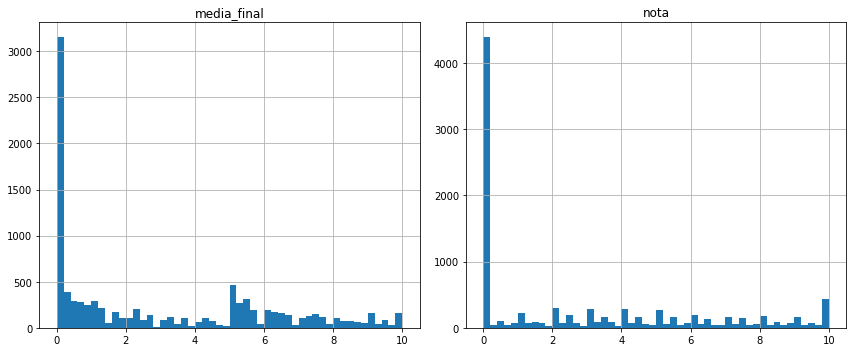

In [21]:
import matplotlib.pyplot as plt

df_finalSemDup[['media_final','nota']].hist(bins=50, figsize=(12,5))
plt.tight_layout()
plt.show()

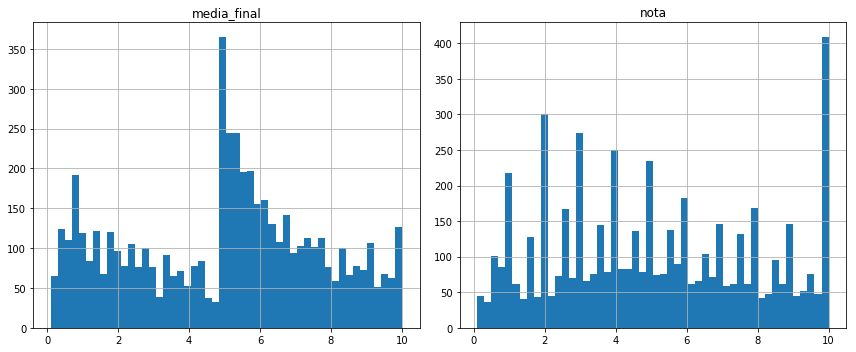

In [22]:
# retirando as notas zero pra ver melhor o comportamento das outras notas
sem_zero = df_finalSemDup[(df_finalSemDup['media_final']!=0) &
                          (df_finalSemDup['nota']!=0)]
sem_zero[['media_final','nota']].hist(bins=50, figsize=(12,5))
plt.tight_layout()
plt.show()

In [77]:
df_finalSemDup.columns

Index(['descricao', 'discente', 'faltas_unidade', 'id_turma', 'media_final',
       'nota', 'numero_total_faltas', 'reposicao', 'unidade', 'anoperiodo'],
      dtype='object')

In [169]:
# criando um DataFrame onde as colunas são as notas das unidade
# função que retorna as colunas sendo as notas das unidades
# específica para o caso de 3 unidades
def cols_unidades(dataFrame):
    notas_1 = dataFrame[dataFrame['unidade']==1.0]
    notas_1 = notas_1[['discente','nota']]
    notas_1 = notas_1.rename(index=str, columns={"nota": "nota_1"})

    notas_2 = dataFrame[dataFrame['unidade']==2.0]
    notas_2 = notas_2[['discente','nota']]
    notas_2 = notas_2.rename(index=str, columns={"nota": "nota_2"})

    notas_3 = dataFrame[dataFrame['unidade']==3.0]
    notas_3 = notas_3[['discente','nota']]
    notas_3 = notas_3.rename(index=str, columns={"nota": "nota_3"})
    
    # o numero de faltas acabou influenciando negativamente
    # total_faltas = dataFrame[['discente','numero_total_faltas']]
    # faltas = pd.merge(total_faltas,notas_1,on='discente')

    notas_12 = pd.merge(notas_1,notas_2,on='discente')
    df_porUnidade = pd.merge(notas_12,notas_3,on='discente')

    return df_porUnidade

In [170]:
df_porUnidade = cols_unidades(df_finalSemDup)
df_porUnidade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3378 entries, 0 to 3377
Data columns (total 4 columns):
discente    3378 non-null object
nota_1      3275 non-null float64
nota_2      3265 non-null float64
nota_3      3255 non-null float64
dtypes: float64(3), object(1)
memory usage: 132.0+ KB


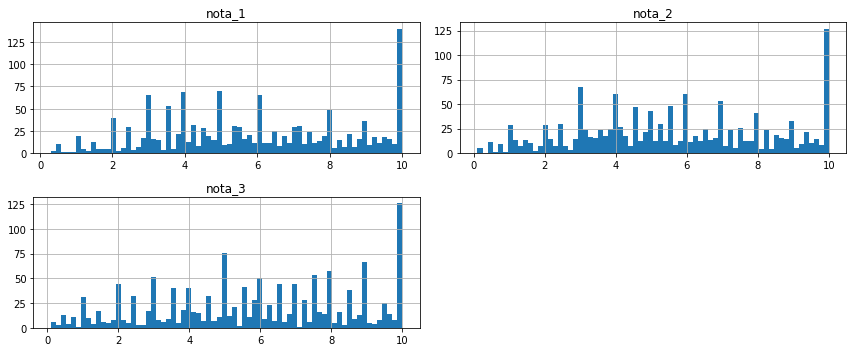

In [171]:
sem_zero2 = df_porUnidade[(df_porUnidade['nota_1']!=0) &
                          (df_porUnidade['nota_2']!=0) &
                          (df_porUnidade['nota_3']!=0)]

sem_zero2.hist(bins=70, figsize=(12,5))
plt.tight_layout()
plt.show()

## 2.6 Conjunto de Teste

In [172]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_finalSemDup, 
                                       test_size=0.2, 
                                       random_state=35)

print("data has {} instances\n {} train instances\n {} test intances".
      format(len(df_finalSemDup),len(train_set),len(test_set)))

data has 12388 instances
 9910 train instances
 2478 test intances


# 3.0 Visualizando os dados

In [173]:
treinamento = train_set.copy()

In [174]:
cols_train = ['descricao','discente','id_turma','media_final','nota','reposicao','unidade',
              'numero_total_faltas']
treinamento = treinamento[cols_train]

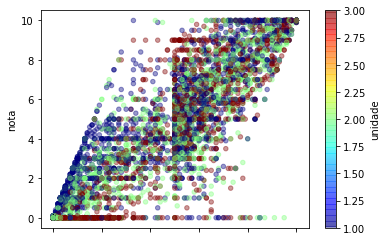

In [175]:
treinamento.plot(kind="scatter", x="media_final", y="nota", alpha=0.4,
           c="unidade", cmap=plt.get_cmap("jet"), colorbar=True)
# plt.legend()

- Há uma concentração de notas aproximadamente zero na terceira unidade e essas pessoas obtiveram uma média final baixa.
- Há também um pequeno grupo que se deu bem nas notas da terceira unidade, aproximadamente 9 e sua média final está entre 5 e 6, mostra que se recuperaram ao longe das unidades.

In [176]:
corr_matrix = treinamento.corr()
corr_matrix["nota"].sort_values(ascending=False)

nota                   1.000000
media_final            0.915609
id_turma               0.043542
unidade               -0.060077
numero_total_faltas   -0.413059
Name: nota, dtype: float64

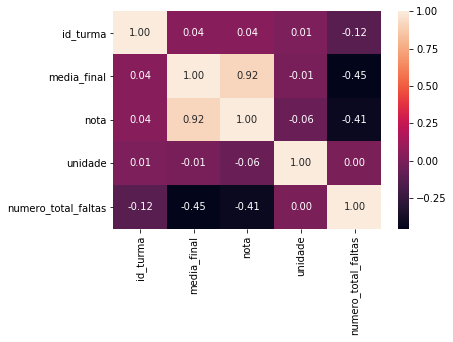

In [177]:
import seaborn as sns

sns.heatmap(treinamento.corr(), annot=True, fmt=".2f")

A correlação apenas confirma o que já é óbvio, que as notas das unidades influenciam na média final do discente.

(array([0.5, 1.5, 2.5]), <a list of 3 Text yticklabel objects>)

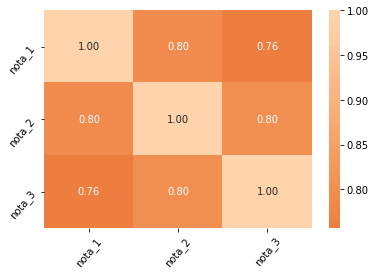

In [178]:
sns.heatmap(df_porUnidade.corr(), annot=True, fmt=".2f",center=0)
plt.xticks(rotation=50)
plt.yticks(rotation=50)

Acima, é possível observar que a correlação entre as notas das unidades são muito fortes e que o número total de faltas possui uma relação linear inversa à nota das unidades.

In [179]:
treinamento.head()

,descricao,discente,id_turma,media_final,nota,reposicao,unidade,numero_total_faltas
1989,APROVADO POR NOTA,6383e6aacfd2aa8a91b33b04ed3db69a,1242595,5.7,2.3,t,2.0,4.0
10612,REPROVADO POR MÉDIA E POR FALTAS,abe06fe4287a886d52fc0e464cbe9819,57585724,0.0,0.0,f,3.0,30.0
14029,REPROVADO,83f9b88bb4e1b945543ebee90a3549e1,57585709,0.0,0.0,f,2.0,0.0
13842,REPROVADO,0f7491d43540602955431a8d7086914a,57585709,1.0,2.0,f,1.0,0.0
17031,REPROVADO,30d35140f1087638c8eab23835cc6c0f,57595053,3.6,2.2,f,1.0,8.0


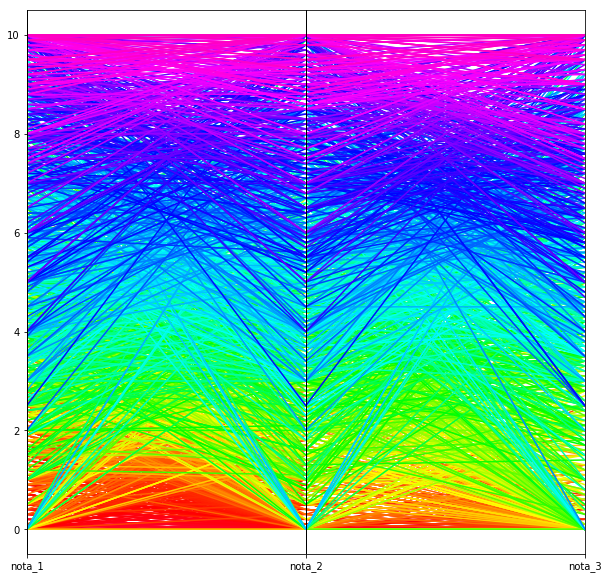

In [180]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(10,10))
df_grafico = df_porUnidade[['nota_1', 'nota_2', 'nota_3']]
df_grafico = df_grafico.fillna(0)
df_grafico['media'] = round(df_grafico.mean(axis=1),2)

df_grafOrd = df_grafico.head(3000)
df_grafOrd = df_grafOrd.sort_values(by='media')

eixo = plt.gca()

parallel_coordinates(frame=df_grafOrd, class_column='media', colormap='gist_rainbow', ax=eixo)
eixo.legend_.remove()

Acima observasse o comportamento de 3000 discentes em relação ao seu desempenhos nas unidades.

# 4.0 Tratando os dados

In [182]:
train_setCopy = train_set.copy()

train_setUni = cols_unidades(train_setCopy)
print(train_setUni.shape)
train_setUni.info()

(1715, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1715 entries, 0 to 1714
Data columns (total 4 columns):
discente    1715 non-null object
nota_1      1668 non-null float64
nota_2      1664 non-null float64
nota_3      1659 non-null float64
dtypes: float64(3), object(1)
memory usage: 67.0+ KB


In [183]:
train_X = train_setUni.drop("nota_3", axis=1)

# y = nota da terceira unidade
train_y = train_setUni.nota_3.copy()


## 4.1 Limpeza de Dados

In [184]:
# substutir os NaN pela mediana
mediana = train_y.median()
train_y = train_y.fillna(mediana)

In [185]:
# vendo a quantidade de elementos ausentes
train_X.isnull().sum()

discente     0
nota_1      47
nota_2      51
dtype: int64

In [186]:
train_set.columns

Index(['descricao', 'discente', 'faltas_unidade', 'id_turma', 'media_final',
       'nota', 'numero_total_faltas', 'reposicao', 'unidade', 'anoperiodo'],
      dtype='object')

In [187]:
# substituindo os valores ausentes pela média dos outros valores
# da respectiva coluna

from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

# criando uma copia sem os elementos não numéricos
train_X_num = train_X.drop("discente", axis=1)

imputer.fit(train_X_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [188]:
imputer.statistics_

array([2.20000005, 1.5       ])

In [189]:
train_X_num.median().values

array([2.20000005, 1.5       ])

In [190]:
# substituindo os valores ausentes pela média encontrada
train_X_num_array = imputer.transform(train_X_num)
train_X_num_df = pd.DataFrame(train_X_num_array, columns=train_X_num.columns)

In [191]:
train_X_num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 2 columns):
nota_1    1715 non-null float64
nota_2    1715 non-null float64
dtypes: float64(2)
memory usage: 26.9 KB


## 4.2 Transformadores Personalizados

In [195]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

# indices das colunas
nota_1ix, nota_2ix = 0, 1

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, add_uni1_pela_uni2 = True):
        self.add_uni1_pela_uni2 = add_uni1_pela_uni2

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):     
        if self.add_uni1_pela_uni2:
            # para não ocorrer divisão por zero
            denominador = X[:, nota_2ix]
            denominador[denominador<.000001] = .000001

            uni1_pela_uni2 = X[:, nota_1ix] / denominador

            return np.c_[X, uni1_pela_uni2]
        else:            
            return np.c_[X]

## 4.3 Pipelines de Transformação

In [196]:
train_X_num_df.head()

,nota_1,nota_2
0,0.0,0.0
1,5.2,1.0
2,10.0,8.8
3,4.9,5.1
4,4.0,4.0


In [197]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


num_pipeline = Pipeline([('imputer', Imputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())
                        ])
train_X_num_pipeline = num_pipeline.fit_transform(train_X_num_df)

In [198]:
train_X_num_pipeline

array([[-0.96772412, -0.86917306, -0.2892435 ],
       [ 0.66137704, -0.55927065, -0.28923781],
       [ 2.16516285,  1.85797067, -0.28924226],
       ...,
       [ 1.44459884,  2.04391225, -0.2892426 ],
       [-0.96772412, -0.86917306, -0.2892435 ],
       [-0.65443543, -0.86917306,  0.80434376]])

# 5.0 Selecionando e Treinando o Modelo

In [199]:
from sklearn.linear_model import LinearRegression

# criando o modelo de  LinearRegression
lin_reg = LinearRegression()

# fit it
lin_reg.fit(train_X_num_pipeline, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [200]:
# Testar com algumas instâncias

some_data = train_X_num_df.iloc[:5]
some_labels = train_y.iloc[:5]
some_data_prepared = num_pipeline.transform(some_data)

# previsões
print("Previsões da terceira nota:", lin_reg.predict(some_data_prepared)) 

Previsões da terceira nota: [-4.63162447e-04  2.40420107e+00  8.45675446e+00  4.58276581e+00
  3.64995200e+00]


In [201]:
# comparando os valores:
print("Labels:", list(some_labels))

Labels: [0.0, 3.5, 5.0, 3.0, 9.0]


In [202]:
# utilizando mean_squared_error do sklearn
from sklearn.metrics import mean_squared_error

previsão_nota3 = lin_reg.predict(train_X_num_pipeline)
lin_mse = mean_squared_error(train_y, previsão_nota3)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.9810372692883158

In [203]:
# Cell Configuration for plotly over google colab
# This method pre-populates the outputframe with the configuration that Plotly
# expects and must be executed for every cell which is displaying a Plotly graph.
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [205]:
import numpy as np
import pandas as pd
# plotly online requires login and password
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# basic functions to run on google colab
configure_plotly_browser_state()
init_notebook_mode(connected=False)

# create a generic layout
layout = go.Layout(width=500,height=400)

# generate a histogram from column median_house_value 
notas_3 = [go.Box(y=train_y,
                        name='Notas da Unidade 3',
                        boxmean=True)]

# create a figure and plot in notebook. 
# if you wish save the hmtl, change iplot to plot
fig = go.Figure(data=notas_3,layout=layout)
pyo.iplot(fig)

Enquanto que a Regressão Linear obteve mediana igual a 1.98,  no boxplot pode-se observar que o valor exato é 2.61, sendo 0.63 o erro.

# 6.0 Apresentando a Solução

In [207]:
final_model = lin_reg
# transfor o df em notas por unidade
test_set_cols_per_unid = cols_unidades(test_set)

# test_X = nota 1 e nota 2
test_X = test_set_cols_per_unid.drop(["discente","nota_3"], axis=1)

# test_y = nota 3
test_y = test_set_cols_per_unid["nota_3"].copy()
mediana = train_y.median()
test_y = test_y.fillna(mediana)

# prepara o dado
test_X_prepared = num_pipeline.transform(test_X)

final_predictions = lin_reg.predict(test_X_prepared)
final_mse = mean_squared_error(test_y, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

1.7268598630119945


In [155]:
# comparando
# basic functions to run on google colab
configure_plotly_browser_state()
init_notebook_mode(connected=False)

# create a generic layout
layout = go.Layout(width=500,height=400)

# generate a histogram from column median_house_value 
notas_3 = [go.Box(y=test_y,
                        name='Notas da Unidade 3',
                        boxmean=True)]

# create a figure and plot in notebook. 
# if you wish save the hmtl, change iplot to plot
fig = go.Figure(data=notas_3,layout=layout)
pyo.iplot(fig)

A previsão deu uma nota de 1.7356, enquanto que no boxplot vemos 2.783, ou seja, um erro de aproximadamente 1. Talvez isso se dê pela presença de poucos parâmetros, visto que foi utilizado apenas a nota da primeira unidade e da segunda unidade. Uma outra possibilidade seria testar outros algoritmos e ver se há algum que possua um comportamento melhor que o de Regressão Linear.